# Lab | Data Aggregation and Filtering

In this challenge, we will continue to work with customer data from an insurance company. We will use the dataset called marketing_customer_analysis.csv, which can be found at the following link:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv

This dataset contains information such as customer demographics, policy details, vehicle information, and the customer's response to the last marketing campaign. Our goal is to explore and analyze this data by first performing data cleaning, formatting, and structuring.

1. Create a new DataFrame that only includes customers who have a total_claim_amount greater than $1,000 and have a response of "Yes" to the last marketing campaign.

In [1]:
import pandas as pd


In [2]:
# Load the dataset
url = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv'
df = pd.read_csv(url)


In [3]:
# Inspect the first few rows and columns
print(df.head())
print(df.columns)


   Unnamed: 0 Customer       State  Customer Lifetime Value Response  \
0           0  DK49336     Arizona              4809.216960       No   
1           1  KX64629  California              2228.525238       No   
2           2  LZ68649  Washington             14947.917300       No   
3           3  XL78013      Oregon             22332.439460      Yes   
4           4  QA50777      Oregon              9025.067525       No   

   Coverage Education Effective To Date EmploymentStatus Gender  ...  \
0     Basic   College           2/18/11         Employed      M  ...   
1     Basic   College           1/18/11       Unemployed      F  ...   
2     Basic  Bachelor           2/10/11         Employed      M  ...   
3  Extended   College           1/11/11         Employed      M  ...   
4   Premium  Bachelor           1/17/11    Medical Leave      F  ...   

   Number of Open Complaints Number of Policies     Policy Type        Policy  \
0                        0.0                  9  Corp

In [4]:
# Remove any leading/trailing spaces in column names and convert to lowercase
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Check for unique values in the 'response' column
print(df['response'].unique())


['No' 'Yes' nan]


In [5]:
# Convert 'response' column to lowercase for consistency if necessary
df['response'] = df['response'].str.strip().str.lower()

# Filter the DataFrame
filtered_df = df[
    (df['total_claim_amount'] > 1000) &
    (df['response'] == 'yes')
]


In [6]:
# Inspect the filtered DataFrame
print(filtered_df.head())
print(filtered_df.shape)  # Print the shape to see the number of rows and columns


     unnamed:_0 customer       state  customer_lifetime_value response  \
189         189  OK31456  California             11009.130490      yes   
236         236  YJ16163      Oregon             11009.130490      yes   
419         419  GW43195      Oregon             25807.063000      yes   
442         442  IP94270     Arizona             13736.132500      yes   
587         587  FJ28407  California              5619.689084      yes   

     coverage             education effective_to_date employmentstatus gender  \
189   Premium              Bachelor           1/24/11         Employed      F   
236   Premium              Bachelor           1/24/11         Employed      F   
419  Extended               College           2/13/11         Employed      F   
442   Premium                Master           2/13/11         Disabled      F   
587   Premium  High School or Below           1/26/11       Unemployed      M   

     ...  number_of_open_complaints number_of_policies     policy_ty

In [7]:
import pandas as pd

# Load the dataset
url = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv'
df = pd.read_csv(url)

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Check unique values in 'response' column to understand current format
print(df['response'].unique())

# Clean 'response' column values
df['response'] = df['response'].str.strip().str.lower()

# Filter the DataFrame
filtered_df = df[
    (df['total_claim_amount'] > 1000) &
    (df['response'] == 'yes')
]

# Inspect the result
print(filtered_df.head())
print(filtered_df.shape)  # Print the shape to see the number of rows and columns


['No' 'Yes' nan]
     unnamed:_0 customer       state  customer_lifetime_value response  \
189         189  OK31456  California             11009.130490      yes   
236         236  YJ16163      Oregon             11009.130490      yes   
419         419  GW43195      Oregon             25807.063000      yes   
442         442  IP94270     Arizona             13736.132500      yes   
587         587  FJ28407  California              5619.689084      yes   

     coverage             education effective_to_date employmentstatus gender  \
189   Premium              Bachelor           1/24/11         Employed      F   
236   Premium              Bachelor           1/24/11         Employed      F   
419  Extended               College           2/13/11         Employed      F   
442   Premium                Master           2/13/11         Disabled      F   
587   Premium  High School or Below           1/26/11       Unemployed      M   

     ...  number_of_open_complaints number_of_polic

2. Using the original Dataframe, analyze the average total_claim_amount by each policy type and gender for customers who have responded "Yes" to the last marketing campaign. Write your conclusions.

In [8]:
import pandas as pd

# Load the dataset
url = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv'
df = pd.read_csv(url)

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Clean 'response' column values
df['response'] = df['response'].str.strip().str.lower()


In [9]:
# Filter the DataFrame for customers who responded "Yes"
yes_responses_df = df[df['response'] == 'yes']


In [10]:
# Calculate average total claim amount by policy type and gender
average_claim_amount = yes_responses_df.groupby(['policy_type', 'gender'])['total_claim_amount'].mean().reset_index()

# Rename columns for clarity
average_claim_amount.columns = ['Policy Type', 'Gender', 'Average Total Claim Amount']


      Policy Type Gender  Average Total Claim Amount
0  Corporate Auto      F                  433.738499
1  Corporate Auto      M                  408.582459
2   Personal Auto      F                  452.965929
3   Personal Auto      M                  457.010178
4    Special Auto      F                  453.280164
5    Special Auto      M                  429.527942


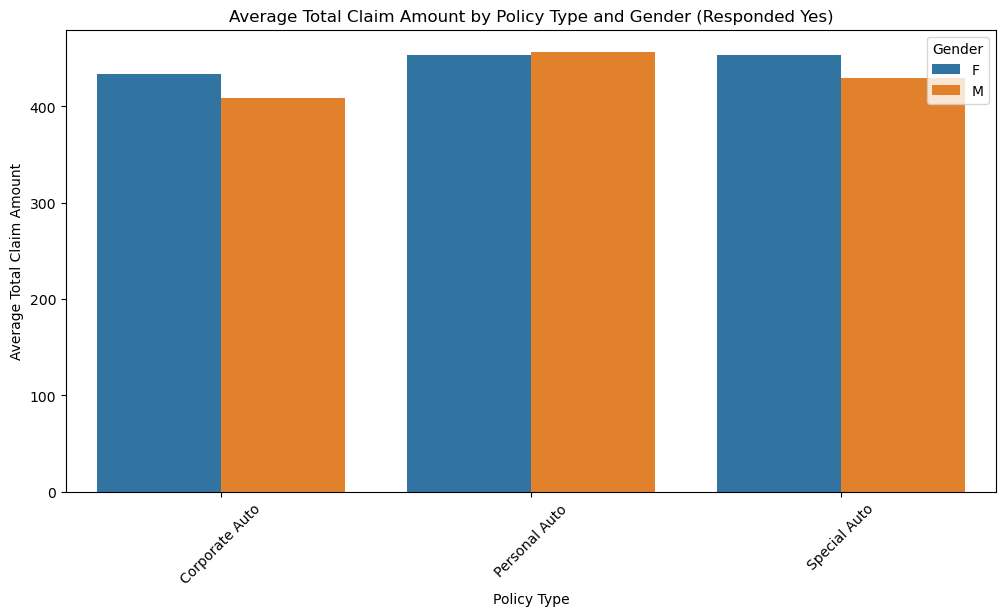

In [11]:
# Inspect the result
print(average_claim_amount)

# Optionally, display in a more readable format
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(data=average_claim_amount, x='Policy Type', y='Average Total Claim Amount', hue='Gender')
plt.title('Average Total Claim Amount by Policy Type and Gender (Responded Yes)')
plt.xticks(rotation=45)
plt.show()


      Policy Type Gender  Average Total Claim Amount
0  Corporate Auto      F                  433.738499
1  Corporate Auto      M                  408.582459
2   Personal Auto      F                  452.965929
3   Personal Auto      M                  457.010178
4    Special Auto      F                  453.280164
5    Special Auto      M                  429.527942


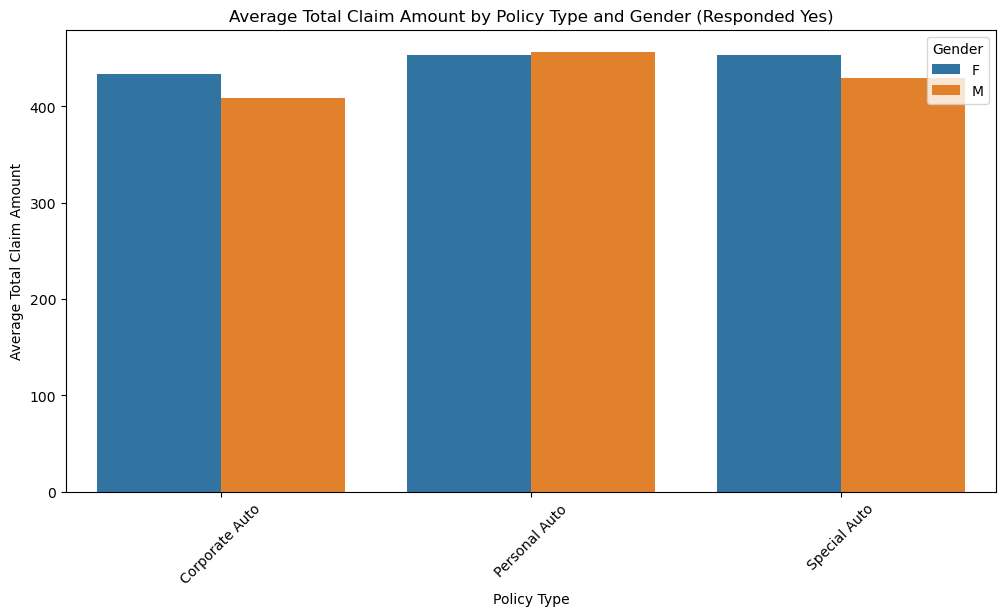

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
url = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv'
df = pd.read_csv(url)

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Clean 'response' column values
df['response'] = df['response'].str.strip().str.lower()

# Filter the DataFrame for customers who responded "Yes"
yes_responses_df = df[df['response'] == 'yes']

# Calculate average total claim amount by policy type and gender
average_claim_amount = yes_responses_df.groupby(['policy_type', 'gender'])['total_claim_amount'].mean().reset_index()

# Rename columns for clarity
average_claim_amount.columns = ['Policy Type', 'Gender', 'Average Total Claim Amount']

# Inspect the result
print(average_claim_amount)

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(data=average_claim_amount, x='Policy Type', y='Average Total Claim Amount', hue='Gender')
plt.title('Average Total Claim Amount by Policy Type and Gender (Responded Yes)')
plt.xticks(rotation=45)
plt.show()


3. Analyze the total number of customers who have policies in each state, and then filter the results to only include states where there are more than 500 customers.

In [13]:
import pandas as pd

# Load the dataset
url = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv'
df = pd.read_csv(url)

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')


In [14]:
# Count the number of customers per state
customer_counts_by_state = df['state'].value_counts().reset_index()

# Rename columns for clarity
customer_counts_by_state.columns = ['State', 'Number of Customers']


In [15]:
# Filter states with more than 500 customers
states_above_500 = customer_counts_by_state[customer_counts_by_state['Number of Customers'] > 500]

# Inspect the result
print(states_above_500)


        State  Number of Customers
0  California                 3552
1      Oregon                 2909
2     Arizona                 1937
3      Nevada                  993
4  Washington                  888


In [16]:
import pandas as pd

# Load the dataset
url = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv'
df = pd.read_csv(url)

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Count the number of customers per state
customer_counts_by_state = df['state'].value_counts().reset_index()

# Rename columns for clarity
customer_counts_by_state.columns = ['State', 'Number of Customers']

# Filter states with more than 500 customers
states_above_500 = customer_counts_by_state[customer_counts_by_state['Number of Customers'] > 500]

# Inspect the result
print(states_above_500)


        State  Number of Customers
0  California                 3552
1      Oregon                 2909
2     Arizona                 1937
3      Nevada                  993
4  Washington                  888


C:\Users\le Roj\AppData\Local\Temp\ipykernel_13780\2635373660.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=customer_counts_by_state, x='State', y='Number of Customers', palette='viridis')


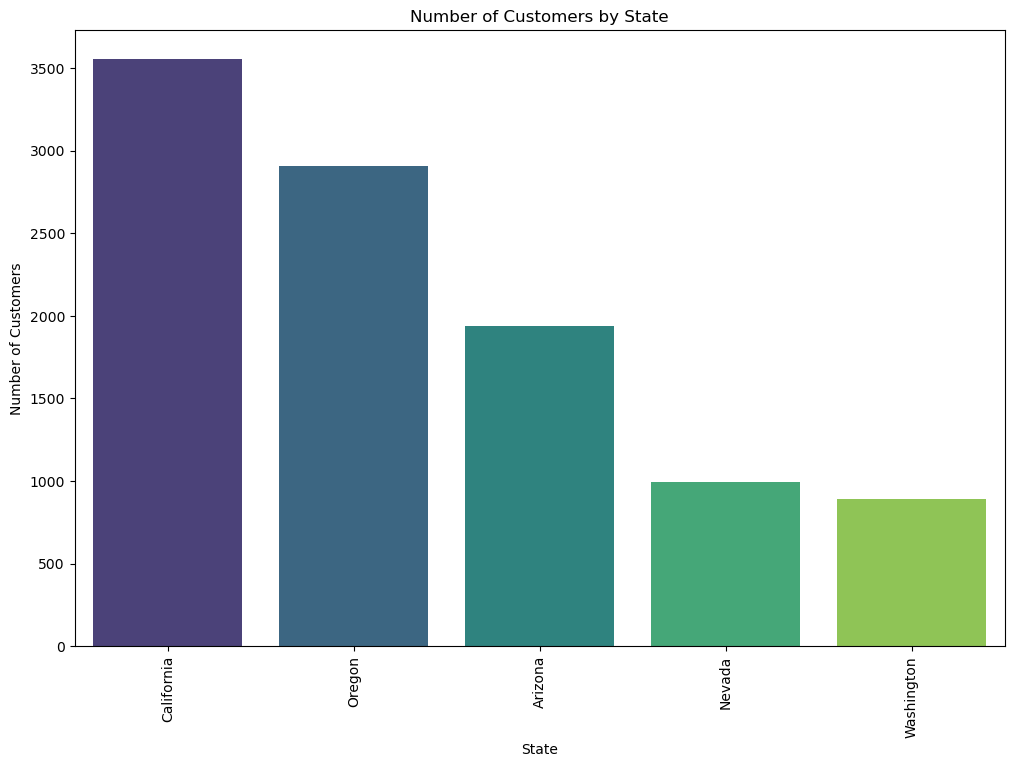

C:\Users\le Roj\AppData\Local\Temp\ipykernel_13780\2635373660.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=states_above_500, x='State', y='Number of Customers', palette='viridis')


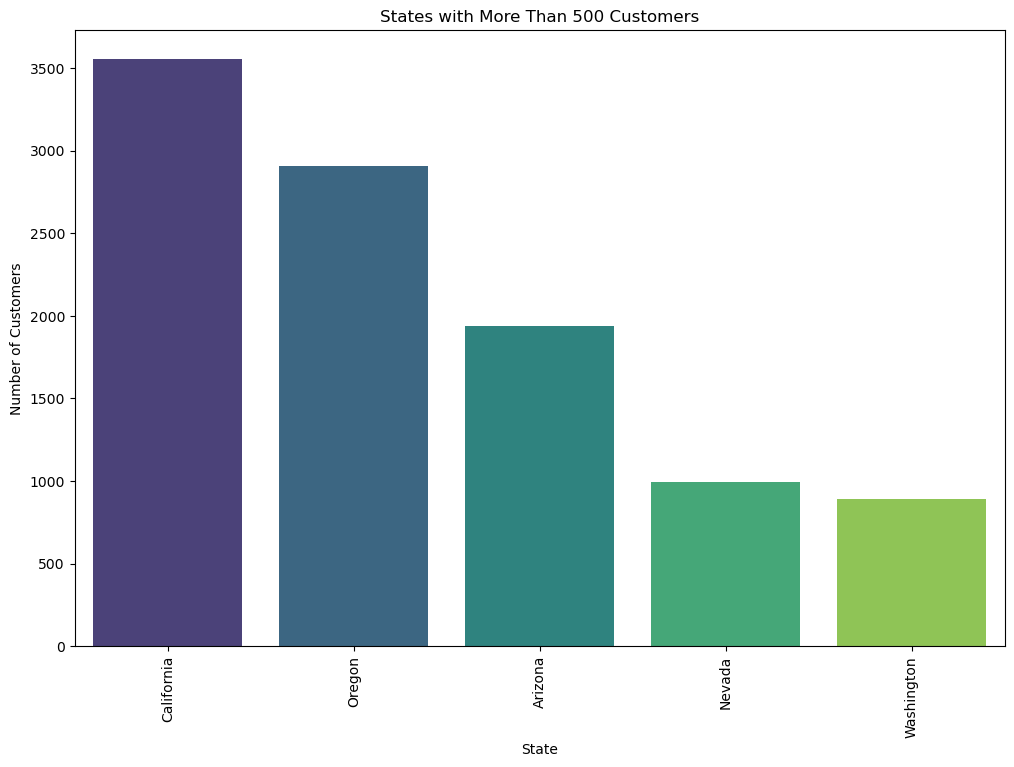

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the customer distribution by state
plt.figure(figsize=(12, 8))
sns.barplot(data=customer_counts_by_state, x='State', y='Number of Customers', palette='viridis')
plt.title('Number of Customers by State')
plt.xticks(rotation=90)
plt.show()

# Plot states with more than 500 customers
plt.figure(figsize=(12, 8))
sns.barplot(data=states_above_500, x='State', y='Number of Customers', palette='viridis')
plt.title('States with More Than 500 Customers')
plt.xticks(rotation=90)
plt.show()


4. Find the maximum, minimum, and median customer lifetime value by education level and gender. Write your conclusions.

In [19]:
print(df['customer_lifetime_value'].dtype)


float64


In [20]:
df['customer_lifetime_value'] = df['customer_lifetime_value'].astype(str)


In [21]:
df['customer_lifetime_value'] = df['customer_lifetime_value'].str.replace('%', '').astype(float)


In [22]:
print(df['customer_lifetime_value'].head())


0     4809.216960
1     2228.525238
2    14947.917300
3    22332.439460
4     9025.067525
Name: customer_lifetime_value, dtype: float64


In [23]:
import pandas as pd

# Cargar el dataset
url = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv'
df = pd.read_csv(url)

# Limpiar nombres de columnas
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Verificar tipo de datos de 'customer_lifetime_value'
print(df['customer_lifetime_value'].dtype)

# Convertir la columna a string si no está en formato string
if df['customer_lifetime_value'].dtype != 'object':
    df['customer_lifetime_value'] = df['customer_lifetime_value'].astype(str)

# Limpiar 'customer_lifetime_value'
df['customer_lifetime_value'] = df['customer_lifetime_value'].str.replace('%', '').astype(float)

# Verificar los primeros valores de la columna para asegurar que la limpieza se realizó correctamente
print(df['customer_lifetime_value'].head())


float64
0     4809.216960
1     2228.525238
2    14947.917300
3    22332.439460
4     9025.067525
Name: customer_lifetime_value, dtype: float64


In [24]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10910 entries, 0 to 10909
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   unnamed:_0                     10910 non-null  int64  
 1   customer                       10910 non-null  object 
 2   state                          10279 non-null  object 
 3   customer_lifetime_value        10910 non-null  float64
 4   response                       10279 non-null  object 
 5   coverage                       10910 non-null  object 
 6   education                      10910 non-null  object 
 7   effective_to_date              10910 non-null  object 
 8   employmentstatus               10910 non-null  object 
 9   gender                         10910 non-null  object 
 10  income                         10910 non-null  int64  
 11  location_code                  10910 non-null  object 
 12  marital_status                 10910 non-null 

## Bonus

5. The marketing team wants to analyze the number of policies sold by state and month. Present the data in a table where the months are arranged as columns and the states are arranged as rows.

In [25]:
import pandas as pd

# Load the dataset
url = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv'
df = pd.read_csv(url)

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Verify the columns
print(df.columns)

# Check if there's a 'policy_date' column or similar
# Assuming there is a column 'policy_date' which needs to be converted to datetime
# If the column has a different name, replace 'policy_date' with the actual name

if 'policy_date' in df.columns:
    df['policy_date'] = pd.to_datetime(df['policy_date'], errors='coerce')  # Convert to datetime

    # Extract month and year from policy_date
    df['month'] = df['policy_date'].dt.to_period('M')
    df['year'] = df['policy_date'].dt.year

    # Check the extracted columns
    print(df[['policy_date', 'month', 'year']].head())

    # Count the number of policies sold by state and month
    pivot_table = df.pivot_table(
        index='state',  # States as rows
        columns='month',  # Months as columns
        values='policy_id',  # Column to count policies
        aggfunc='count',  # Count the number of policies
        fill_value=0  # Replace NaN with 0
    )

    # Reset index to get the DataFrame in the desired format
    pivot_table.reset_index(inplace=True)

    # Display the resulting table
    print(pivot_table)
else:
    print("Column 'policy_date' not found in the dataset.")


Index(['unnamed:_0', 'customer', 'state', 'customer_lifetime_value',
       'response', 'coverage', 'education', 'effective_to_date',
       'employmentstatus', 'gender', 'income', 'location_code',
       'marital_status', 'monthly_premium_auto', 'months_since_last_claim',
       'months_since_policy_inception', 'number_of_open_complaints',
       'number_of_policies', 'policy_type', 'policy', 'renew_offer_type',
       'sales_channel', 'total_claim_amount', 'vehicle_class', 'vehicle_size',
       'vehicle_type'],
      dtype='object')
Column 'policy_date' not found in the dataset.


6.  Display a new DataFrame that contains the number of policies sold by month, by state, for the top 3 states with the highest number of policies sold.

*Hint:*
- *To accomplish this, you will first need to group the data by state and month, then count the number of policies sold for each group. Afterwards, you will need to sort the data by the count of policies sold in descending order.*
- *Next, you will select the top 3 states with the highest number of policies sold.*
- *Finally, you will create a new DataFrame that contains the number of policies sold by month for each of the top 3 states.*

In [26]:
import pandas as pd

# Load the dataset
url = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv'
df = pd.read_csv(url)

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Check the columns available
print(df.columns)

# Convert policy_date to datetime if there's a column named 'policy_date'
if 'policy_date' in df.columns:
    df['policy_date'] = pd.to_datetime(df['policy_date'], errors='coerce')  # Convert to datetime

    # Extract month and year from policy_date
    df['month'] = df['policy_date'].dt.to_period('M')
    
    # Check the extracted columns
    print(df[['policy_date', 'month']].head())

    # Group by state and month, then count the number of policies
    policy_counts = df.groupby(['state', 'month']).size().reset_index(name='policy_count')
    
    # Find the total number of policies sold by state
    state_totals = policy_counts.groupby('state')['policy_count'].sum().reset_index()
    
    # Get the top 3 states with the highest number of policies sold
    top_states = state_totals.sort_values(by='policy_count', ascending=False).head(3)['state']
    
    # Filter the policy_counts DataFrame to include only the top 3 states
    top_states_policy_counts = policy_counts[policy_counts['state'].isin(top_states)]

    # Pivot table to have months as columns and states as rows
    pivot_table = top_states_policy_counts.pivot_table(
        index='state',
        columns='month',
        values='policy_count',
        aggfunc='sum',  # Sum the counts in case of multiple entries
        fill_value=0    # Replace NaN with 0
    )

    # Reset index to get the DataFrame in the desired format
    pivot_table.reset_index(inplace=True)

    # Display the resulting table
    print(pivot_table)
else:
    print("Column 'policy_date' not found in the dataset.")


Index(['unnamed:_0', 'customer', 'state', 'customer_lifetime_value',
       'response', 'coverage', 'education', 'effective_to_date',
       'employmentstatus', 'gender', 'income', 'location_code',
       'marital_status', 'monthly_premium_auto', 'months_since_last_claim',
       'months_since_policy_inception', 'number_of_open_complaints',
       'number_of_policies', 'policy_type', 'policy', 'renew_offer_type',
       'sales_channel', 'total_claim_amount', 'vehicle_class', 'vehicle_size',
       'vehicle_type'],
      dtype='object')
Column 'policy_date' not found in the dataset.


7. The marketing team wants to analyze the effect of different marketing channels on the customer response rate.

Hint: You can use melt to unpivot the data and create a table that shows the customer response rate (those who responded "Yes") by marketing channel.

External Resources for Data Filtering: https://towardsdatascience.com/filtering-data-frames-in-pandas-b570b1f834b9

In [28]:
import pandas as pd

# Cargar el dataset
url = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv'
df = pd.read_csv(url)

# Limpiar nombres de columnas
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Verificar las columnas del DataFrame
print("Columnas disponibles en el DataFrame:")
print(df.columns)

# Asumamos que las columnas de los canales de marketing son 'marketing_channel_1', 'marketing_channel_2', etc.
# Ajusta esta lista de acuerdo con los nombres reales de las columnas en tu DataFrame
channels = [col for col in df.columns if 'channel' in col]

# Verificar si 'response' y los canales de marketing están en el DataFrame
if 'response' in df.columns and all(channel in df.columns for channel in channels):
    # Unpivot the dataset to have marketing channels in one column
    melted_df = pd.melt(df, id_vars=['response'], value_vars=channels, var_name='marketing_channel', value_name='value')

    # Filtrar para clientes que respondieron 'Yes'
    response_df = melted_df[melted_df['response'] == 'Yes']

    # Calcular la cantidad de respuestas y el número total de clientes por canal
    response_counts = response_df.groupby('marketing_channel').size().reset_index(name='response_count')
    total_counts = melted_df.groupby('marketing_channel').size().reset_index(name='total_count')

    # Unir las cantidades de respuestas con los totales
    response_summary = pd.merge(response_counts, total_counts, on='marketing_channel')

    # Calcular las tasas de respuesta
    response_summary['response_rate'] = response_summary['response_count'] / response_summary['total_count'] * 100

    # Mostrar la tabla resumen resultante
    print("Resumen de tasas de respuesta por canal de marketing:")
    print(response_summary)

else:
    print("Verifica que las columnas 'response' y los canales de marketing están presentes en el DataFrame.")


Columnas disponibles en el DataFrame:
Index(['unnamed:_0', 'customer', 'state', 'customer_lifetime_value',
       'response', 'coverage', 'education', 'effective_to_date',
       'employmentstatus', 'gender', 'income', 'location_code',
       'marital_status', 'monthly_premium_auto', 'months_since_last_claim',
       'months_since_policy_inception', 'number_of_open_complaints',
       'number_of_policies', 'policy_type', 'policy', 'renew_offer_type',
       'sales_channel', 'total_claim_amount', 'vehicle_class', 'vehicle_size',
       'vehicle_type'],
      dtype='object')
Resumen de tasas de respuesta por canal de marketing:
  marketing_channel  response_count  total_count  response_rate
0     sales_channel            1466        10910      13.437214
